# Preprocessing and pileup

In [ ]:
# luca-cnv-numbat kernel

# We want to download the patient-matched samples ( PA060: N254 and PA067: N586)
# Then run Numbat on the samples 1) individually, 2) combined

# Run pileup step with c5.9xlarge because ncores can be used to parallelized

conda activate luca-cnv-numbat
ln -s "/home/ubuntu/InstallTemp/numbat/Eagle_v2.4.1/eagle" "${CONDA_PREFIX}/bin/eagle"  # IMPORTANT!


numbat_out="/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/numbat"
numbat_input="${numbat_out}/input"
mkdir -p ${numbat_input}
NUMBAT="/home/ubuntu/InstallTemp/numbat"
cores=$(nproc)

In [ ]:
# Download the matched samples and their indexes, then do pileup

for sample in NSCL-PA067-5p-GEX nsclpa060_5p NSCLC_N254 NSCLC_N586
do
    echo "Starting ${sample}" | ts '[%Y-%m-%d %H:%M:%S]'

    bam_local="${numbat_input}/${sample}_possorted_genome.bam"
    barcodefile="${numbat_input}/${sample}_barcodes.tsv"
    outdir="${numbat_out}/${sample}"
    mkdir -p ${outdir}
    logfile="${outdir}/${sample}_log.txt"
    pileup_donefile="${outdir}/finished.checkpoint"

    if [ ! -f "${barcodefile}" ]
    then
        echo "Downloading BAM files for sample ${sample} from server" | ts '[%Y-%m-%d %H:%M:%S]'
        aws s3 cp s3://nscl-seq/cellranger/v5.0.1/${sample}/possorted_genome_bam.bam $bam_local
        aws s3 cp s3://nscl-seq/cellranger/v5.0.1/${sample}/possorted_genome_bam.bam.bai ${bam_local}.bai
        echo "Making barcode file" | ts '[%Y-%m-%d %H:%M:%S]'
        samtools view $bam_local | egrep -wo "CB:Z:.*?UR" | \
            awk '{print $1}' | awk -F ":" '{arr[$3] = 1} END {for (key in arr) {print key}}' > $barcodefile
    else
        echo "BAM file ${bam_local} already exists; not re-downloading" | ts '[%Y-%m-%d %H:%M:%S]'
    fi


    # Then run the numbat pileup here
    if [ ! -f "${pileup_donefile}" ]
    then
        echo "Running Numbat on ${sample}; log at ${logfile}" | ts '[%Y-%m-%d %H:%M:%S]'
        
        # Run on r5.4xlarge; TODO: Add benchmark numbers for pileup
        # For a single 17GB BAM file, creating barcode 
        # file took from 20:34 to 21:12 (38 min).
        # Running the pileup took from 21:12 to  01:20:03 2 days later

        Rscript /home/ubuntu/miniconda3/envs/luca-cnv-numbat/lib/R/library/numbat/bin/pileup_and_phase.R \
            --label ${sample} \
            --samples ${sample} \
            --bams ${bam_local} \
            --barcodes ${barcodefile} \
            --outdir ${outdir} \
            --gmap "${NUMBAT}/Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz" \
            --eagle "${CONDA_PREFIX}/bin/eagle" \
            --snpvcf "${NUMBAT}/genome1K.phase3.SNP_AF5e2.chr1toX.hg38.vcf" \
            --paneldir "${NUMBAT}/1000G_hg38" \
            --ncores "${cores}" 2>&1 | ts '[%Y-%m-%d %H:%M:%S]' \
                > "${logfile}"
        
        if ! grep -q "Execution halted" <(tail -n 5 "${logfile}")
        then
            echo "Sample ${sample} finished successfully" | ts '[%Y-%m-%d %H:%M:%S]'
            touch ${pileup_donefile}
            # rm ${bam_local} ${barcodefile}
        else
            echo "Sample ${sample}" finished unsuccessfully | ts '[%Y-%m-%d %H:%M:%S]'
        fi
    fi
done

In [ ]:
# Now combine the matched samples and rerun pileup
# TODO: Add the headers

for i in 1 2
do
    if [ "$i" -eq 1 ]; then
      sample="combined1"
      headerfile="${numbat_input}/rg_PA067_N586.txt"
      merge_bam="${numbat_input}/${sample}.bam"
    elif [ "$i" -eq 2 ]; then
      sample="combined2"
      headerfile="${numbat_input}/rg_PA060_N254.txt"
      merge_bam="${numbat_input}/${sample}.bam"
    fi

    echo "Starting ${sample}" | ts '[%Y-%m-%d %H:%M:%S]'
    barcodefile="${numbat_input}/${sample}_barcodes.tsv"
    outdir="${numbat_out}/${sample}"
    mkdir -p ${outdir}
    logfile="${outdir}/${sample}_log.txt"
    pileup_donefile="${outdir}/finished.checkpoint"

    if [ ! -f "${barcodefile}" ]
    then
        echo "Combining BAM files" | ts '[%Y-%m-%d %H:%M:%S]'
        if [ "$i" -eq 1 ]; then
            printf '@RG\tID:PA067\tSM:hs\tLB:PA067\tPL:ILLUMINA\n@RG\tID:N586\tSM:hs\tLB:N586\tPL:LSN586\n' > "${headerfile}"
            samtools merge -rh "${headerfile}" "${merge_bam}" \
                "${numbat_input}/NSCL-PA067-5p-GEX_possorted_genome.bam" \
                "${numbat_input}/NSCLC_N586_possorted_genome.bam"
        elif [ "$i" -eq 2 ]; then
            printf '@RG\tID:PA060\tSM:hs\tLB:PA060\tPL:ILLUMINA\n@RG\tID:N254\tSM:hs\tLB:N254\tPL:LSN254\n' > "${headerfile}"
            samtools merge -rh "${headerfile}" "${merge_bam}" \
                "${numbat_input}/nsclpa060_5p_possorted_genome.bam" \
                "${numbat_input}/NSCLC_N254_possorted_genome.bam"
        fi
        
        echo "Indexing BAM file" | ts '[%Y-%m-%d %H:%M:%S]'
        samtools index -b "${merge_bam}" "${merge_bam}.bai"

        echo "Making barcode file" | ts '[%Y-%m-%d %H:%M:%S]'
        samtools view "${merge_bam}" | egrep -wo "CB:Z:.*?UR" | \
            awk '{print $1}' | awk -F ":" '{arr[$3] = 1} END {for (key in arr) {print key}}' > $barcodefile
    else
        echo "BAM file ${merge_bam} already exists; not re-creating" | ts '[%Y-%m-%d %H:%M:%S]'
    fi


    # Then run the numbat pileup here
    if [ ! -f "${pileup_donefile}" ]
    then
        echo "Running Numbat on ${sample}; log at ${logfile}" | ts '[%Y-%m-%d %H:%M:%S]'

        Rscript /home/ubuntu/miniconda3/envs/luca-cnv-numbat/lib/R/library/numbat/bin/pileup_and_phase.R \
            --label ${sample} \
            --samples ${sample} \
            --bams ${merge_bam} \
            --barcodes ${barcodefile} \
            --outdir ${outdir} \
            --gmap "${NUMBAT}/Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz" \
            --eagle "${CONDA_PREFIX}/bin/eagle" \
            --snpvcf "${NUMBAT}/genome1K.phase3.SNP_AF5e2.chr1toX.hg38.vcf" \
            --paneldir "${NUMBAT}/1000G_hg38" \
            --ncores "${cores}" 2>&1 | ts '[%Y-%m-%d %H:%M:%S]' \
                > "${logfile}"
        
        if ! grep -q "Execution halted" <(tail -n 5 "${logfile}")
        then
            echo "Sample ${sample} finished successfully" | ts '[%Y-%m-%d %H:%M:%S]'
            touch ${pileup_donefile}
            # rm ${bam_local} ${barcodefile}
        else
            echo "Sample ${sample}" finished unsuccessfully | ts '[%Y-%m-%d %H:%M:%S]'
        fi
    fi
done

In [ ]:
# Download counts matrix and reference file

aws s3 cp s3://nscl-seq/revision/snRNAseq/T_cells_v7.rds "${numbat_input}/T_cells_v7.rds"
aws s3 cp s3://nscl-seq/revision/snRNAseq/NSCLC_all_cells_v2.4.rds "${numbat_input}/NSCLC_all.rds"

# Now we need to manually subset the full reference so it doesn't take forever to load

In [3]:
library(Seurat)

out_ref <- '/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/numbat/input/NSCLC_qry.rds'

if (!file.exists(out_ref)) {
  full_ref <- readRDS('/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/numbat/input/NSCLC_all.rds')
  valid_samples <- c('N254', 'N586', 'PA067', 'PA060')
  partial_ref <- subset(full_ref, subset=orig.ident %in% valid_samples)
  saveRDS(partial_ref, out_ref)
}



In [ ]:
# Run the actual Numbat R function

conda activate luca-cnv-numbat

# Took about 1h:10m for GM18 on r5.4xlarge with 16 cores
projectdir="/home/ubuntu/edsouza-summer2023/lung-cancer-cnv"
for i in combined1 combined2 NSCL-PA067-5p-GEX NSCLC_N254 NSCLC_N586 nsclpa060_5p
do
  sample="${i}"
  outdir="${projectdir}/data/numbat/${sample}/numbat_downstream"
  logfile="${outdir}/numbat_log.txt"
  donefile="${outdir}/done.checkpoint"

  mkdir -p ${outdir}

  if [ ! -f "${donefile}" ]
  then
      echo "Starting sample ${sample}. Log at ${logfile}" | ts '[%Y-%m-%d %H:%M:%S]'
      Rscript "${projectdir}/02_Numbat.R" ${sample} 2>&1 | ts '[%Y-%m-%d %H:%M:%S]' > "${logfile}"

      if ! grep -q "Execution halted" <(tail -n 5 "${logfile}")
      then
          echo "Sample ${sample} finished successfully"  | ts '[%Y-%m-%d %H:%M:%S]'
          touch "${donefile}"
      else
          echo "Sample ${sample} finished unsuccessfully" | ts '[%Y-%m-%d %H:%M:%S]'
      fi
  else
      echo "Sample ${sample} already finished; skipping" | ts '[%Y-%m-%d %H:%M:%S]'
  fi
done

# Downstream R analysis

In [1]:
# https://kharchenkolab.github.io/numbat/articles/results.html
# nb$clone_post$clone_opt gives the clones


library(numbat)
library(tidyverse)
library(patchwork)
seu_file <- readRDS('/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/numbat/input/NSCLC_qry.rds')



Loading required package: Matrix

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
compare_clones <- function(pat) {
  nb <- Numbat$new(out_dir=file.path('/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/numbat', 
                   pat, 'numbat_downstream'))

  # c('PA067', 'N586', 'N254', 'PA060')
  if (pat == 'combined1') {
    seu <- subset(seu_file, subset=orig.ident %in% c('PA067', 'N586')) 
  } else if (pat == 'combined2') {
    seu <- subset(seu_file, subset=orig.ident %in% c('N254', 'PA060'))
  } else if (pat == 'NSCL-PA067-5p-GEX') {
    seu <- subset(seu_file, subset=orig.ident %in% c('PA067'))
    pat <- 'PA067'
  } else if (pat == 'NSCLC_N254') {
    seu <- subset(seu_file, subset=orig.ident %in% c('N254'))
    pat <- 'N254'
  } else if (pat == 'NSCLC_N586') {
    seu <- subset(seu_file, subset=orig.ident %in% c('N586'))
    pat <- 'N586'
  } else if (pat == 'nsclpa060_5p') {
    seu <- subset(seu_file, subset=orig.ident %in% c('PA060'))
    pat <- 'PA060'
  } 


  barcode_lookup <- data.frame(barcodes = colnames(seu@assays$RNA@counts)) %>% 
                    tidyr::separate(barcodes, c("sample", "bc"), sep='_', remove=F)
  collision_bc <-  barcode_lookup %>% group_by(bc) %>% 
                  summarize(ct = n()) %>% arrange(-ct) %>% 
                  filter(ct > 1) %>%
                  .$bc
  valid_full_bc <- barcode_lookup %>% filter(!(bc %in% collision_bc)) %>% .$barcodes


  return(list(nb=nb, 
              barcodes=barcode_lookup %>% filter(barcodes %in% valid_full_bc)))
}


pal <- RColorBrewer::brewer.pal(n = 4, name = 'Dark2')
names(pal) <- c('PA067', 'N586', 'N254', 'PA060')


plot_results <- function(comparison, samplename) {
  full_df <- merge(comparison$nb$clone_post, 
                  comparison$barcodes, 
                  by.x='cell', by.y='bc', all.x=T, all.y=F)
  
  p1 <- ggplot(full_df, aes(factor(clone_opt), fill=sample)) +
      geom_bar() +
      xlab('Clone') + ylab('Count') + ggtitle(paste0('Clones in ', samplename)) +
      theme_classic() + scale_fill_manual(values=pal) + 
      theme(legend.position='bottom')

  

  p2 <- comparison$nb$plot_mut_history() + theme(legend.position='bottom') +
          guides(size = guide_legend(nrow = 1))

  comparison$barcodes <- comparison$barcodes %>% 
      mutate(color=pal[sample]) %>% rename(cell=bc)

  p3 <- comparison$nb$plot_phylo_heatmap(
          annot=comparison$barcodes %>% select(cell, sample), 
          annot_scale = scale_fill_manual(values=pal)
        )


  options(repr.plot.width=12, repr.plot.height=10)
  layout <- "AABBBBBB
             CCCCCCCC"
  out <- (p1 + p2 + p3) + plot_layout(design=layout)
  return(out)
}

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”


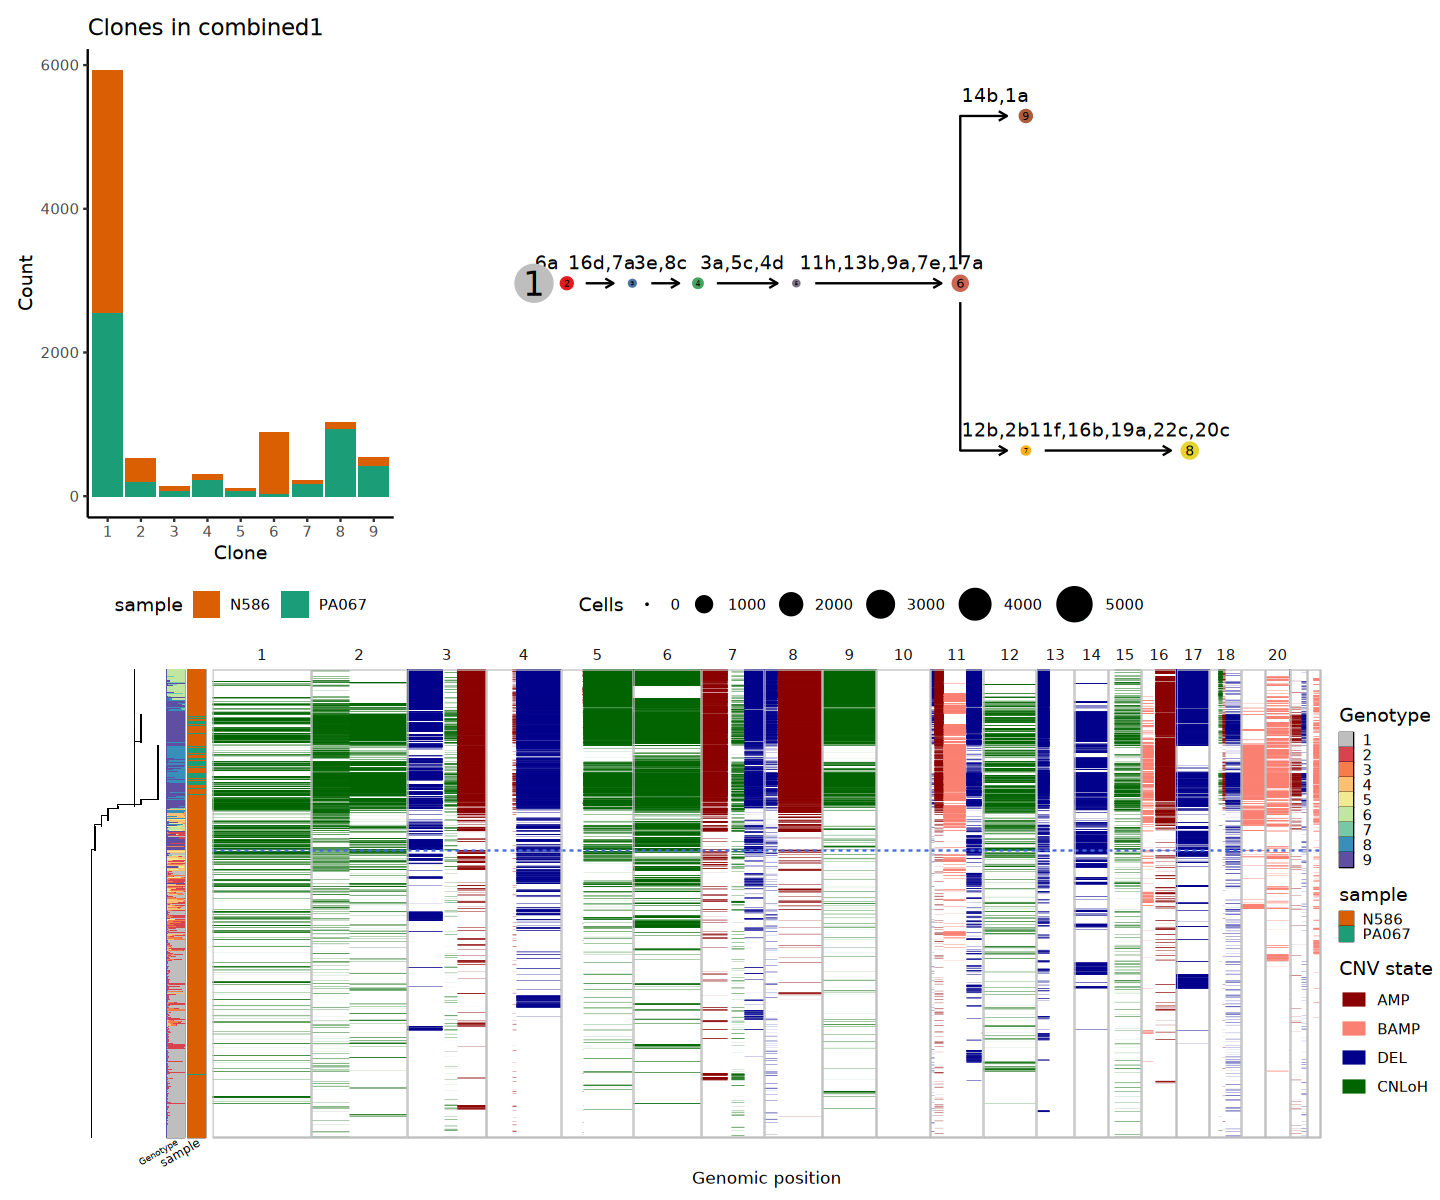

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”


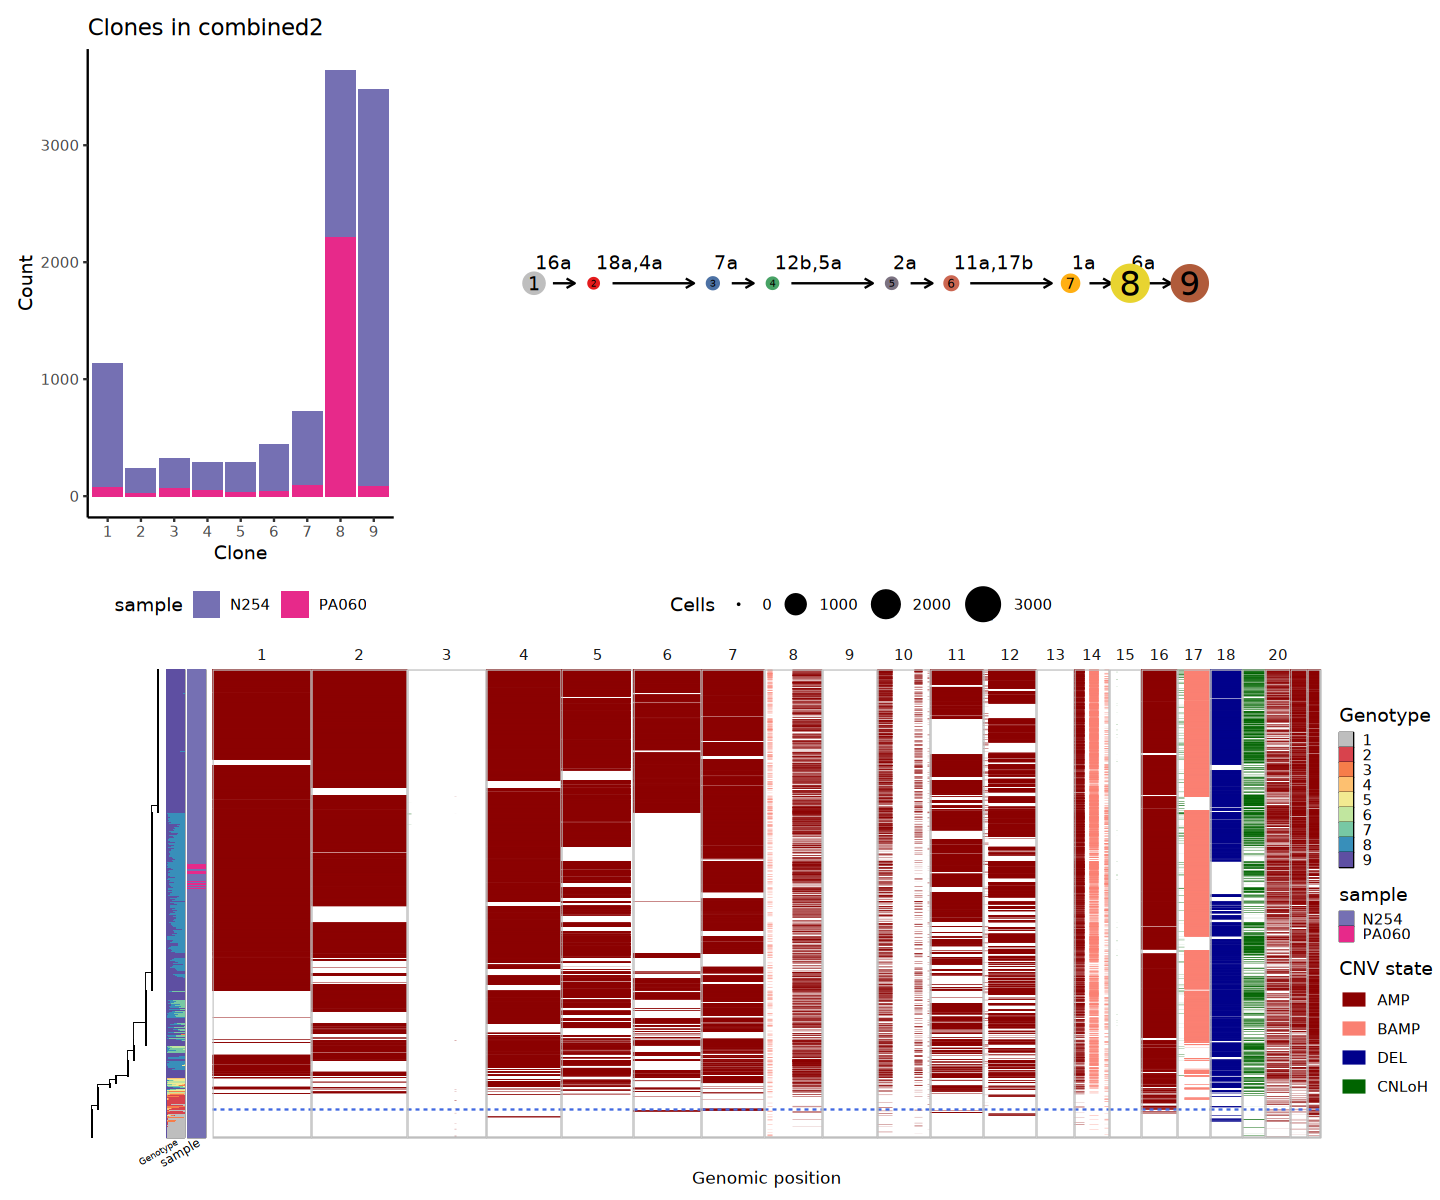

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”


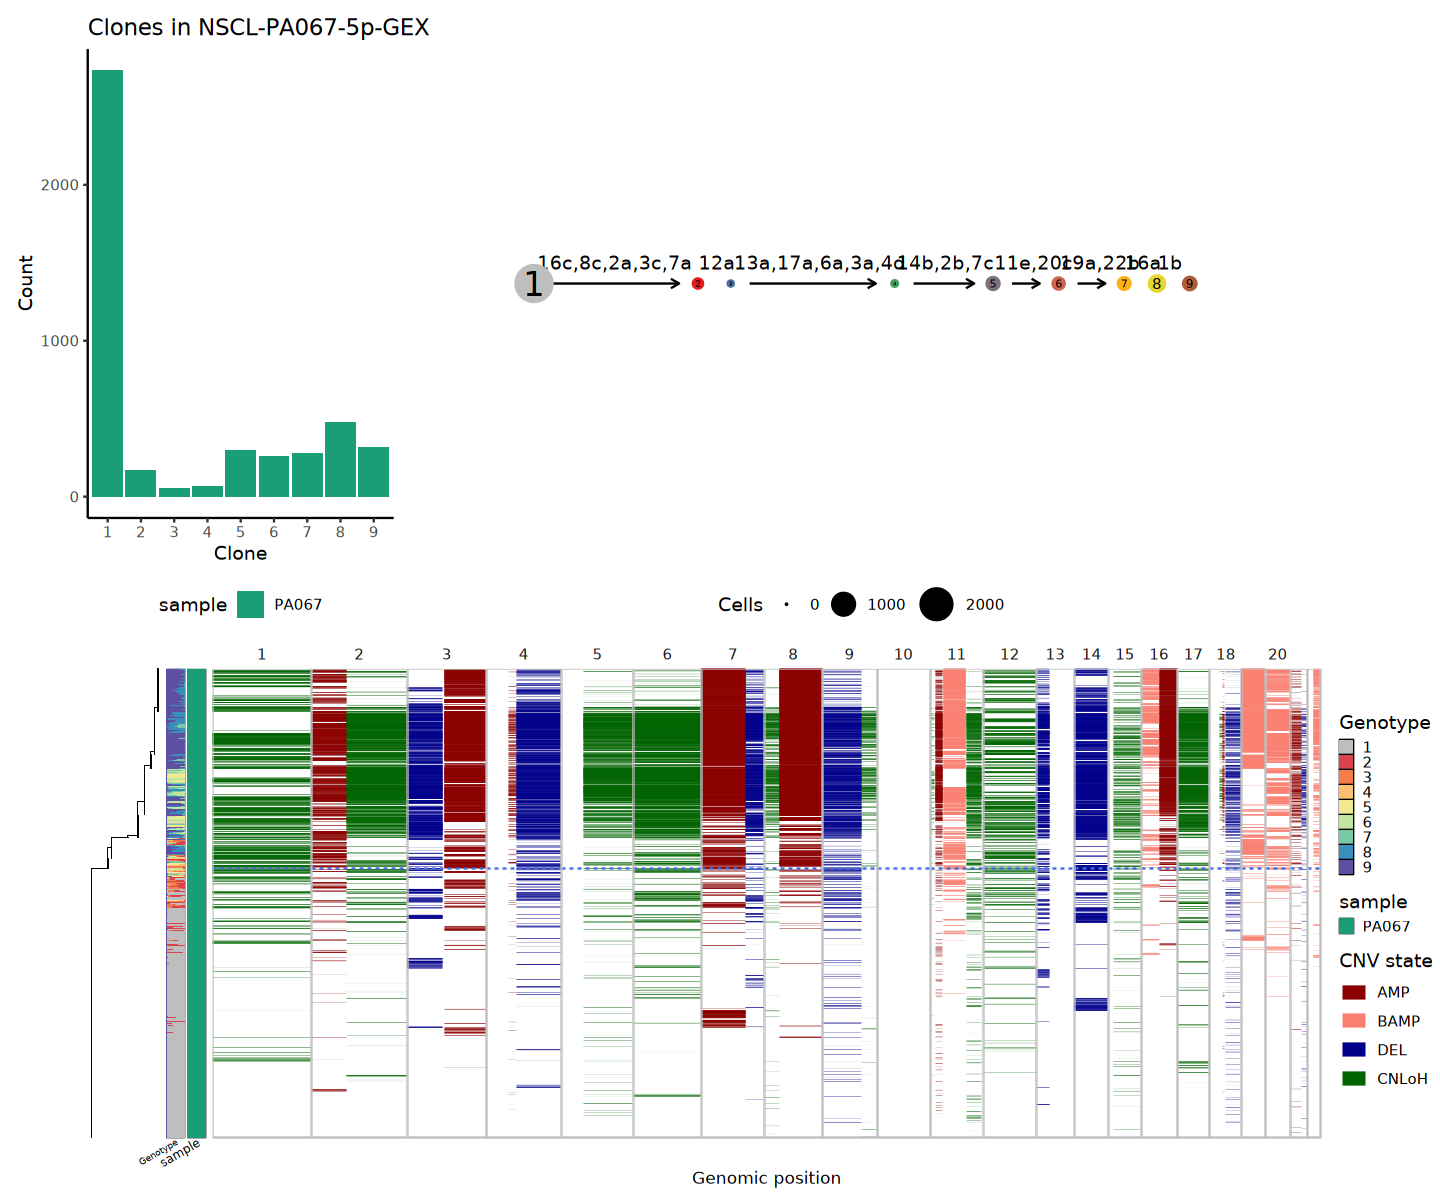

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”


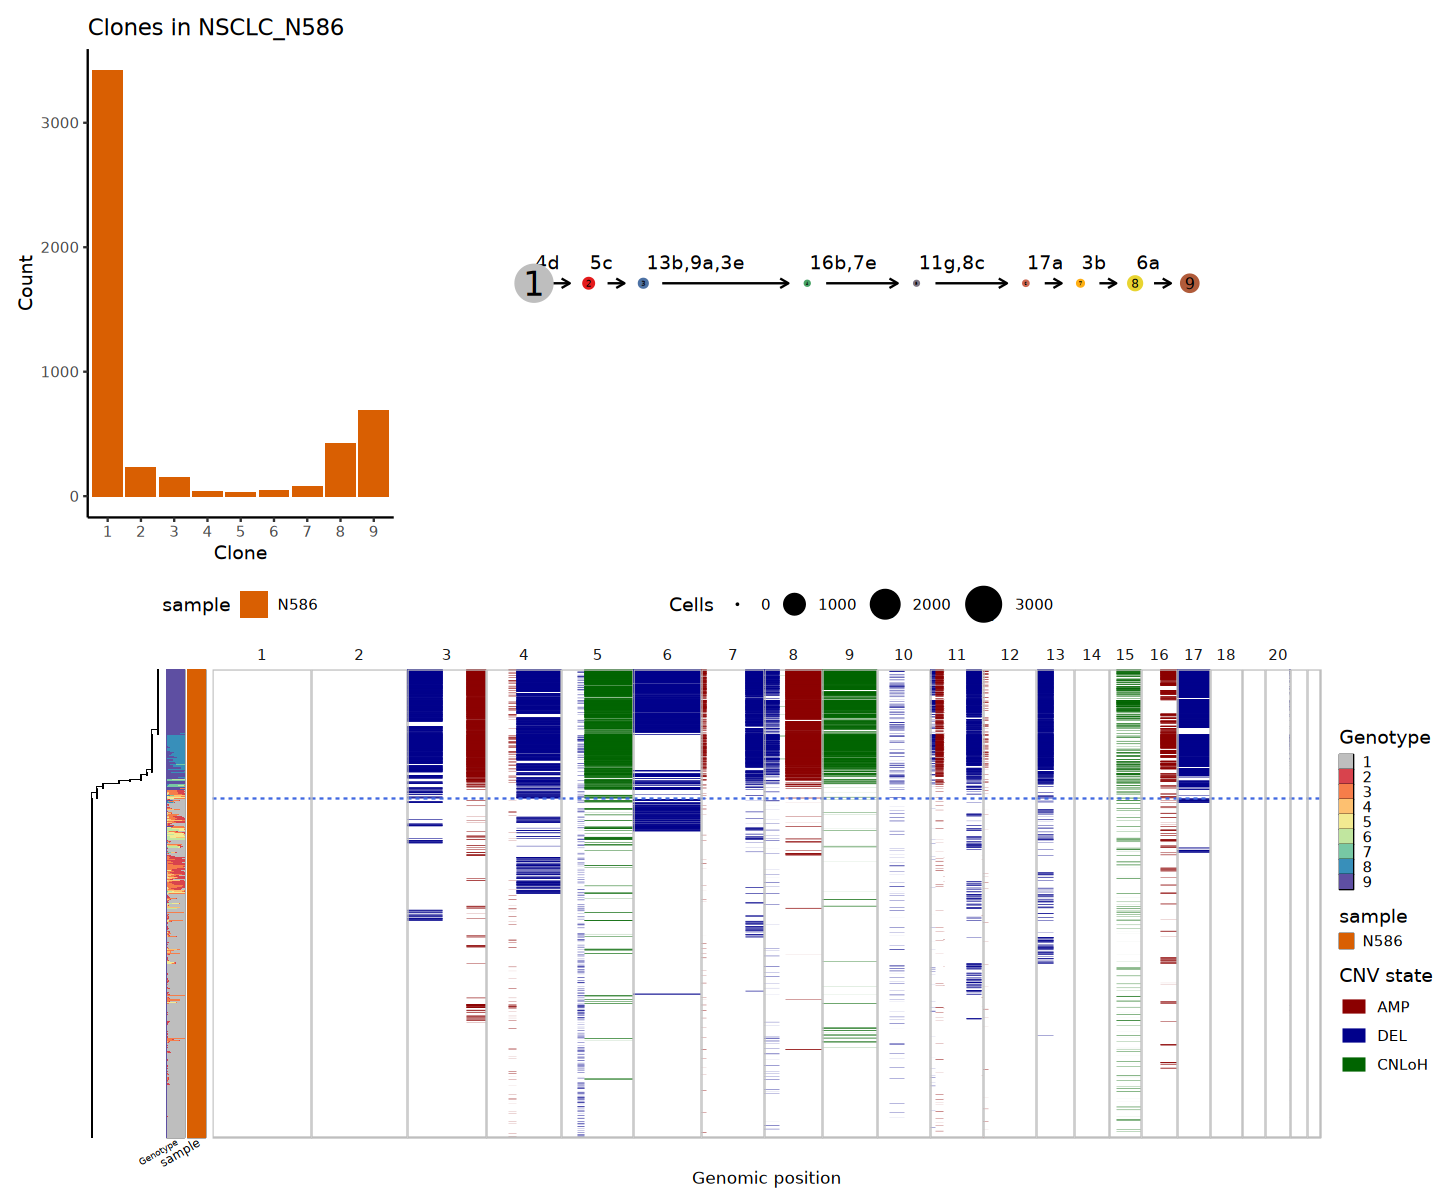

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_tile()`).”


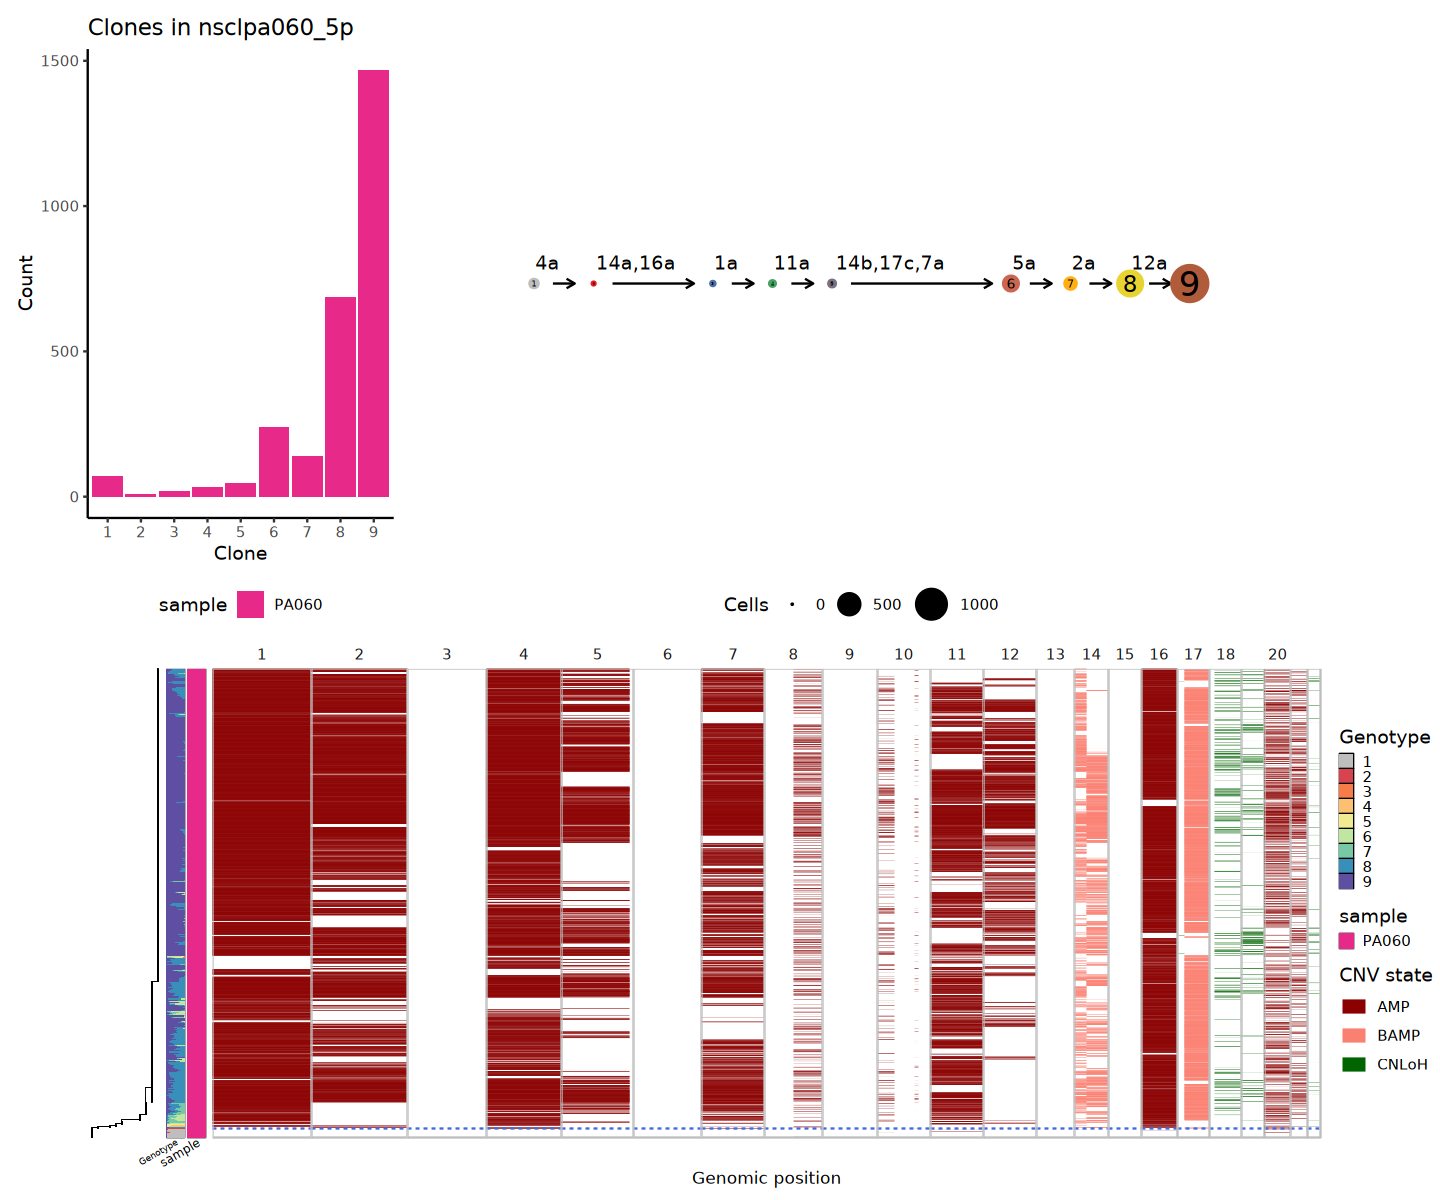

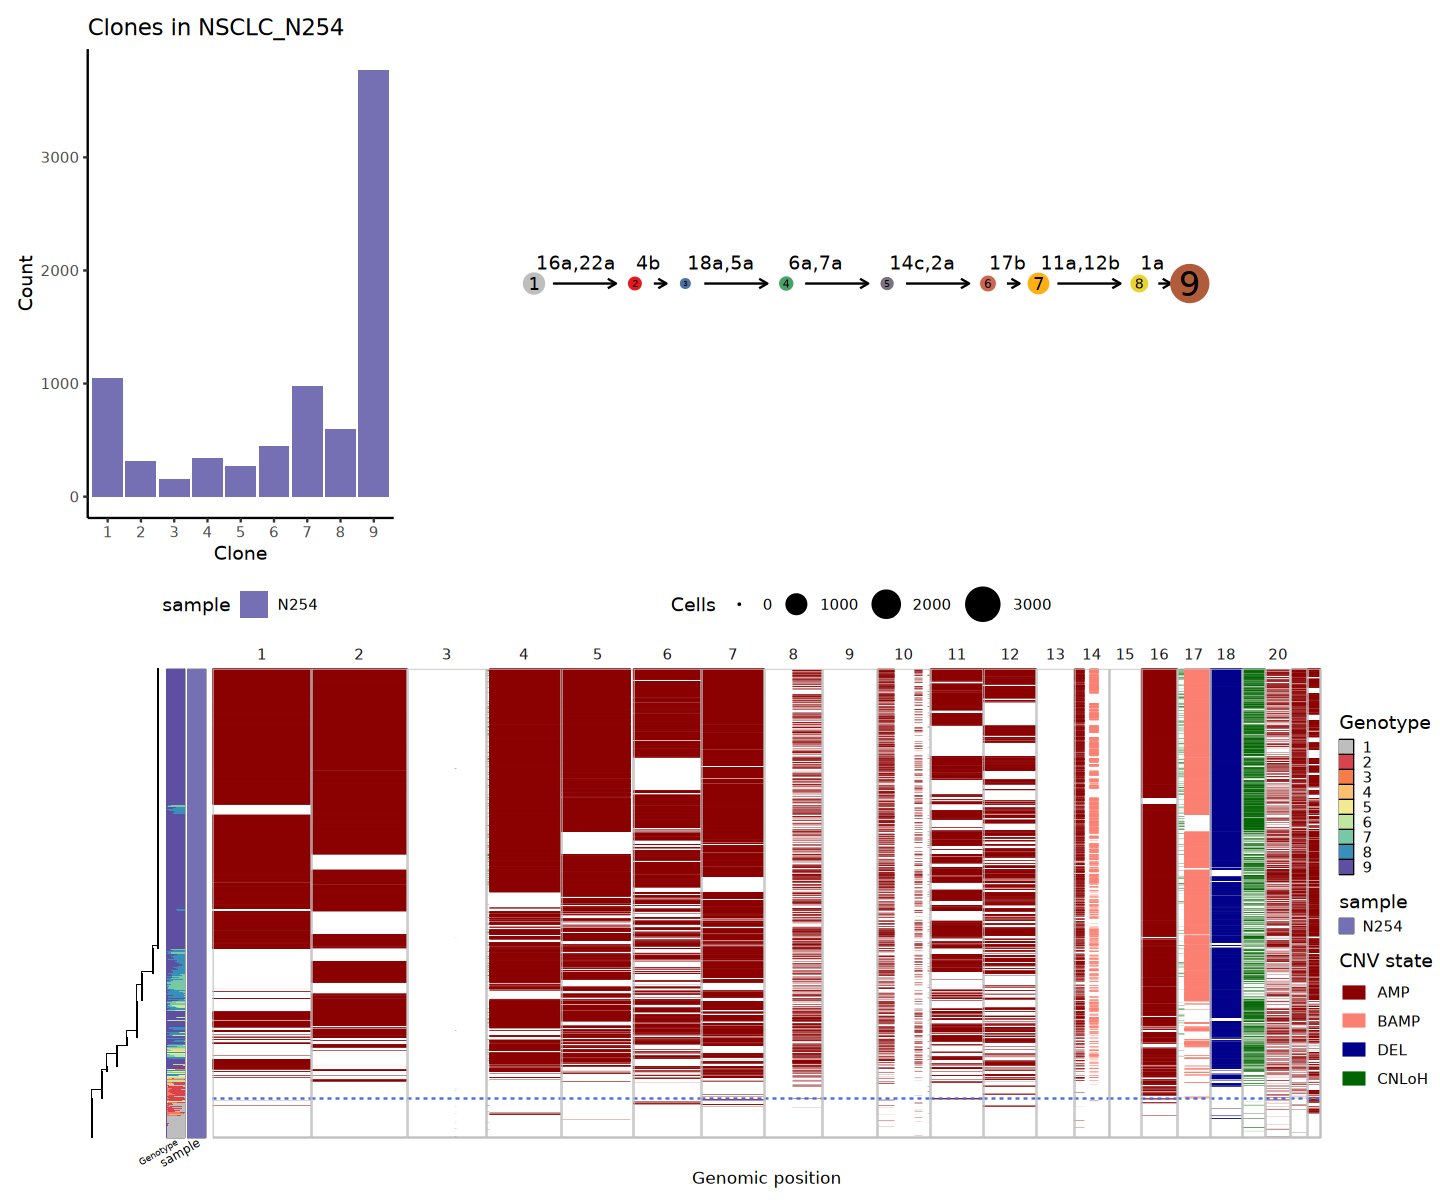

In [6]:
outdir <- '/home/ubuntu/edsouza-summer2023/lung-cancer-cnv/data/out'
if (!dir.exists(outdir)) {
  dir.create(outdir, recursive=T)
}
for (sample in c('combined1', 'combined2', 
                'NSCL-PA067-5p-GEX', 'NSCLC_N586',
                'nsclpa060_5p', 'NSCLC_N254')) {
  obj <- compare_clones(sample)
  obj$nb$cutree(n_cut = 8)
  res <- plot_results(obj, sample)
  print(res)
  ggsave(file.path(outdir, paste0(sample, '_clones.pdf')), plot=res, height=10, width=12)
}